The Notebook for training BERT base model on SQuAD dataset

In [ ]:
 pip install transformers

In [ ]:
import requests
import json
import torch
import torch.nn as nn
import os
from tqdm import tqdm
from transformers import BertModel, BertTokenizerFast, AdamW
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

In [ ]:
MODEL_PATH = "bert-base-uncased"

In [ ]:
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2023-11-30 16:04:06--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.110.153, 185.199.109.153, 185.199.111.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   245MB/s    in 0.2s    

2023-11-30 16:04:07 (245 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2023-11-30 16:04:07--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.110.153, 185.199.109.153, 185.199.111.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       1

In [ ]:
num_questions = 0
num_posible = 0
num_imposible = 0

In [ ]:
def get_data(path):
  with open(path, 'rb') as f:
    raw_data = json.load(f)

  contexts = []
  questions = []
  answers = []
  num_q = 0
  num_pos = 0
  num_imp = 0

  for group in raw_data['data']:
    for paragraph in group['paragraphs']:
      context = paragraph['context']
      for qa in paragraph['qas']:
        question = qa['question']
        num_q  = num_q  +1
        if qa['is_impossible'] == True:
            num_imp = num_imp +1
        else:
            num_pos = num_pos +1
        for answer in qa['answers']:
          contexts.append(context.lower())
          questions.append(question.lower())
          answers.append(answer)

  return num_q, num_pos, num_imp, contexts, questions, answers

In [ ]:
num_q, num_pos, num_imp, train_contexts, train_questions, train_answers = get_data('train-v2.0.json')
num_questions  = num_q
num_posible = num_pos
num_imposible  = num_imp

In [ ]:
print(train_questions[0:10])
print(train_answers[0:10])

['when did beyonce start becoming popular?', 'what areas did beyonce compete in when she was growing up?', "when did beyonce leave destiny's child and become a solo singer?", 'in what city and state did beyonce  grow up? ', 'in which decade did beyonce become famous?', 'in what r&b group was she the lead singer?', 'what album made her a worldwide known artist?', "who managed the destiny's child group?", 'when did beyoncé rise to fame?', "what role did beyoncé have in destiny's child?"]
[{'text': 'in the late 1990s', 'answer_start': 269}, {'text': 'singing and dancing', 'answer_start': 207}, {'text': '2003', 'answer_start': 526}, {'text': 'Houston, Texas', 'answer_start': 166}, {'text': 'late 1990s', 'answer_start': 276}, {'text': "Destiny's Child", 'answer_start': 320}, {'text': 'Dangerously in Love', 'answer_start': 505}, {'text': 'Mathew Knowles', 'answer_start': 360}, {'text': 'late 1990s', 'answer_start': 276}, {'text': 'lead singer', 'answer_start': 290}]


In [ ]:
num_q, num_pos, num_imp, valid_contexts, valid_questions, valid_answers = get_data('dev-v2.0.json')
num_questions  = num_questions + num_q
num_posible = num_posible + num_pos
num_imposible = num_imposible  + num_imp

print(f"Total number of questions: {num_questions}")
print(f"Total number of Answerable questions: {num_posible}")
print(f"Total number of impossible questions: {num_imposible}")

Total number of questions: 142192
Total number of Answerable questions: 92749
Total number of impossible questions: 49443


In [ ]:
print(valid_questions[0:10])
print(valid_answers[0:10])

['in what country is normandy located?', 'in what country is normandy located?', 'in what country is normandy located?', 'in what country is normandy located?', 'when were the normans in normandy?', 'when were the normans in normandy?', 'when were the normans in normandy?', 'when were the normans in normandy?', 'from which countries did the norse originate?', 'from which countries did the norse originate?']
[{'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': '10th and 11th centuries', 'answer_start': 94}, {'text': 'in the 10th and 11th centuries', 'answer_start': 87}, {'text': '10th and 11th centuries', 'answer_start': 94}, {'text': '10th and 11th centuries', 'answer_start': 94}, {'text': 'Denmark, Iceland and Norway', 'answer_start': 256}, {'text': 'Denmark, Iceland and Norway', 'answer_start': 256}]


In [ ]:
def add_answer_end(answers, contexts):
  for answer, context in zip(answers, contexts):
    answer['text'] = answer['text'].lower()
    answer['answer_end'] = answer['answer_start'] + len(answer['text'])

add_answer_end(train_answers, train_contexts)
add_answer_end(valid_answers, valid_contexts)

In [ ]:

print(f"Context: {train_contexts[0]}")
print(f"Question: {train_questions[0]}")
print(f"Answer: {train_answers[0]}")

Context: beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ bee-yon-say) (born september 4, 1981) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r&b girl-group destiny's child. managed by her father, mathew knowles, the group became one of the world's best-selling girl groups of all time. their hiatus saw the release of beyoncé's debut album, dangerously in love (2003), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number-one singles "crazy in love" and "baby boy".
Question: when did beyonce start becoming popular?
Answer: {'text': 'in the late 1990s', 'answer_start': 269, 'answer_end': 286}


In [ ]:
test_rec = 30
print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Answer: {valid_answers[test_rec]}")

Context: the english name "normans" comes from the french words normans/normanz, plural of normant, modern french normand, which is itself borrowed from old low franconian nortmann "northman" or directly from old norse norðmaðr, latinized variously as nortmannus, normannus, or nordmannus (recorded in medieval latin, 9th century) to mean "norseman, viking".
Question: what is the original meaning of the word norman?
Answer: {'text': 'norseman, viking', 'answer_start': 331, 'answer_end': 347}


653


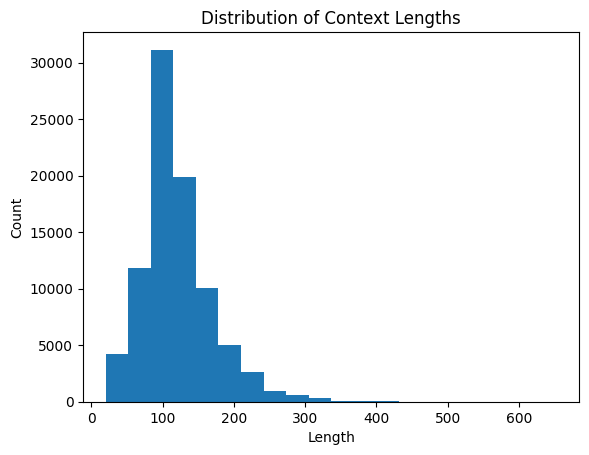

In [ ]:
token_lens = []

for txt in train_contexts:
    txt = txt.strip()
    token_lens.append(len(txt.split(' ')))


print(max(token_lens))

plt.hist(token_lens,  bins=20)
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Context Lengths');

40
86821


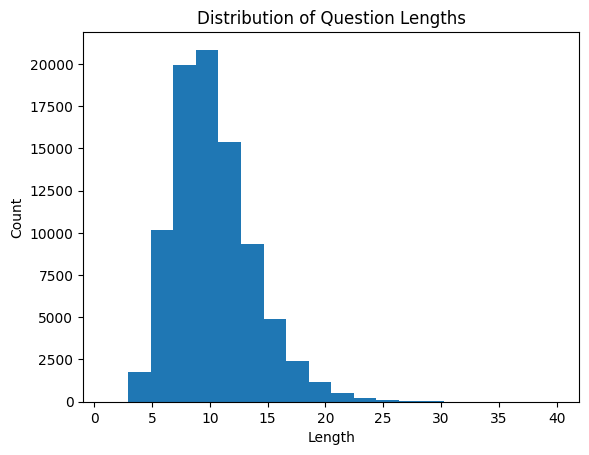

In [ ]:
token_lens2 = []

for txt in train_questions:
    txt = txt.strip()
    token_lens2.append(len(txt.split(' ')))


print(max(token_lens2))
print(len(token_lens2))

plt.hist(token_lens2,  bins=20)
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Question Lengths');

In [ ]:
MAX_LENGTH = 250

In [ ]:
tokenizerFast = BertTokenizerFast.from_pretrained(MODEL_PATH)

train_encodings_fast = tokenizerFast(train_questions, train_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)
valid_encodings_fast = tokenizerFast(valid_questions,valid_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
type(train_encodings_fast)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['input_ids'][1]))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
86821
250


In [ ]:
print(train_encodings_fast['input_ids'][1])
print(tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(train_encodings_fast['input_ids'][1])))

[101, 2054, 2752, 2106, 20773, 5566, 1999, 2043, 2016, 2001, 3652, 2039, 1029, 102, 20773, 21025, 19358, 22815, 1011, 5708, 1006, 1013, 12170, 23432, 29715, 3501, 29678, 12325, 29685, 1013, 10506, 1011, 10930, 2078, 1011, 2360, 1007, 1006, 2141, 2244, 1018, 1010, 3261, 1007, 2003, 2019, 2137, 3220, 1010, 6009, 1010, 2501, 3135, 1998, 3883, 1012, 2141, 1998, 2992, 1999, 5395, 1010, 3146, 1010, 2016, 2864, 1999, 2536, 4823, 1998, 5613, 6479, 2004, 1037, 2775, 1010, 1998, 3123, 2000, 4476, 1999, 1996, 2397, 4134, 2004, 2599, 3220, 1997, 1054, 1004, 1038, 2611, 1011, 2177, 10461, 1005, 1055, 2775, 1012, 3266, 2011, 2014, 2269, 1010, 25436, 22815, 1010, 1996, 2177, 2150, 2028, 1997, 1996, 2088, 1005, 1055, 2190, 1011, 4855, 2611, 2967, 1997, 2035, 2051, 1012, 2037, 14221, 2387, 1996, 2713, 1997, 20773, 1005, 1055, 2834, 2201, 1010, 20754, 1999, 2293, 1006, 2494, 1007, 1010, 2029, 2511, 2014, 2004, 1037, 3948, 3063, 4969, 1010, 3687, 2274, 8922, 2982, 1998, 2956, 1996, 4908, 2980, 2531, 2193

In [ ]:
type(train_answers[0]['text'])
train_answers[0].keys()

dict_keys(['text', 'answer_start', 'answer_end'])

In [ ]:
def ret_Answer_start_and_end_train(idx):     #finds index of answer from context
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(train_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(train_encodings_fast['input_ids'][idx]) -  len(answer_encoding_fast['input_ids']) ):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):

            if (answer_encoding_fast['input_ids'][i] != train_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)

In [ ]:
test_rec=92

z,x = ret_Answer_start_and_end_train(test_rec)
print("z and x are")
print(z, x)

predict_answer_tokens = train_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

z and x are
0 0

split with luckett and rober
[CLS] what event caused beyonce's depression? [SEP] letoya luckett and roberson became unhappy with mathew's managing of the band and eventually were replaced by farrah franklin and michelle williams. beyonce experienced depression following the split with luckett and roberson after being publicly blamed by the media, critics, and blogs for its cause. her long - standing boyfriend left her at this time. the depression was so severe it lasted for a couple of years, during which she occasionally kept herself in her bedroom for days and refused to eat anything. beyonce stated that she struggled to speak about her depression because destiny's child had just won their first grammy award and she feared no one would take her seriously. beyonce would later speak of her mother as the person who helped her fight it. franklin was dismissed, leaving just beyonce, rowland, and williams. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [ ]:
test_rec=1

z,x = ret_Answer_start_and_end_train(test_rec)
print("z and x are")
print(z, x)

predict_answer_tokens = train_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

z and x are
68 71
singing and dancing
singing and dancing
[CLS] what areas did beyonce compete in when she was growing up? [SEP] beyonce giselle knowles - carter ( / biːˈjɒnseɪ / bee - yon - say ) ( born september 4, 1981 ) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny's child. managed by her father, mathew knowles, the group became one of the world's best - selling girl groups of all time. their hiatus saw the release of beyonce's debut album, dangerously in love ( 2003 ), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number - one singles " crazy in love " and " baby boy ". [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
86821


In [ ]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(train_encodings_fast['input_ids'])):
    s, e = ret_Answer_start_and_end_train(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


train_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

1190


In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
86821


In [ ]:
test_rec = 1
print(train_encodings_fast['start_positions'][test_rec])
print(train_encodings_fast['end_positions'][test_rec])
predict_answer_tokens = train_encodings_fast.input_ids[test_rec][train_encodings_fast['start_positions'][test_rec] : train_encodings_fast['end_positions'][test_rec]]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

68
71
singing and dancing
singing and dancing
[CLS] what areas did beyonce compete in when she was growing up? [SEP] beyonce giselle knowles - carter ( / biːˈjɒnseɪ / bee - yon - say ) ( born september 4, 1981 ) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny's child. managed by her father, mathew knowles, the group became one of the world's best - selling girl groups of all time. their hiatus saw the release of beyonce's debut album, dangerously in love ( 2003 ), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number - one singles " crazy in love " and " baby boy ". [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
def ret_Answer_start_and_end_valid(idx):         #finds index of answer from context
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(valid_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(valid_encodings_fast['input_ids'][idx])  -  len(answer_encoding_fast['input_ids'])   ):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            if (answer_encoding_fast['input_ids'][i] != valid_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)

In [ ]:
start_positions = []    #updating start and end positions
end_positions = []
ctr = 0
for h in range(len(valid_encodings_fast['input_ids']) ):
    s, e = ret_Answer_start_and_end_valid(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


valid_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

393


In [ ]:
test_rec=2

z,x = ret_Answer_start_and_end_valid(test_rec)

predict_answer_tokens = valid_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(valid_answers[test_rec]['text'])
print(tokenizerFast.decode(valid_encodings_fast['input_ids'][test_rec]))

france
france
[CLS] in what country is normandy located? [SEP] the normans ( norman : nourmands ; french : normands ; latin : normanni ) were the people who in the 10th and 11th centuries gave their name to normandy, a region in france. they were descended from norse ( " norman " comes from " norseman " ) raiders and pirates from denmark, iceland and norway who, under their leader rollo, agreed to swear fealty to king charles iii of west francia. through generations of assimilation and mixing with the native frankish and roman - gaulish populations, their descendants would gradually merge with the carolingian - based cultures of west francia. the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['start_positions']))
print(len(train_encodings_fast['end_positions']))
print(len(valid_encodings_fast['input_ids']))
print(len(valid_encodings_fast['start_positions']))
print(len(valid_encodings_fast['end_positions']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
86821
86821
86821
20302
20302
20302


In [ ]:
tokenizerFast.decode(train_encodings_fast['input_ids'][0])

'[CLS] when did beyonce start becoming popular? [SEP] beyonce giselle knowles - carter ( / biːˈjɒnseɪ / bee - yon - say ) ( born september 4, 1981 ) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny\'s child. managed by her father, mathew knowles, the group became one of the world\'s best - selling girl groups of all time. their hiatus saw the release of beyonce\'s debut album, dangerously in love ( 2003 ), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number - one singles " crazy in love " and " baby boy ". [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
test_row= 0
print(train_contexts[test_row][train_answers[test_row]['answer_start']:train_answers[test_row]['answer_end']])

in the late 1990s


In [ ]:
answer_start_index = 0
answer_end_index = 100

predict_answer_tokens = train_encodings_fast.input_ids[0][answer_start_index : answer_end_index]
tokenizerFast.decode(predict_answer_tokens)

"[CLS] when did beyonce start becoming popular? [SEP] beyonce giselle knowles - carter ( / biːˈjɒnseɪ / bee - yon - say ) ( born september 4, 1981 ) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny's child. managed by her father, mathew"

In [ ]:
class InputDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][i]),
            'token_type_ids': torch.tensor(self.encodings['token_type_ids'][i]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][i]),
            'start_positions': torch.tensor(self.encodings['start_positions'][i]),
            'end_positions': torch.tensor(self.encodings['end_positions'][i])
        }
    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
train_dataset = InputDataset(train_encodings_fast)
valid_dataset = InputDataset(valid_encodings_fast)

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=32)

In [ ]:
print(len(train_dataset))
print(train_dataset[0].keys())

86821
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])


In [ ]:
bert_model = BertModel.from_pretrained(MODEL_PATH)
class QAModel(nn.Module):
    def __init__(self):
        super(QAModel, self).__init__()
        self.bert = bert_model
        self.drop_out = nn.Dropout(0.1)
        self.l1 = nn.Linear(768 * 2, 768 * 2)
        self.l2 = nn.Linear(768 * 2, 2)
        self.linear_relu_stack = nn.Sequential(
            self.drop_out,
            self.l1,
            nn.LeakyReLU(),
            self.l2
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        model_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)
        hidden_states = model_output[2]
        out = torch.cat((hidden_states[-1], hidden_states[-3]), dim=-1)
        logits = self.linear_relu_stack(out)

        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
model = QAModel()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)/2
    return total_loss

In [ ]:
def focal_loss_fn(start_logits, end_logits, start_positions, end_positions, gamma):

    smax = nn.Softmax(dim=1)
    probs_start = smax(start_logits)
    inv_probs_start = 1 - probs_start
    probs_end = smax(end_logits)
    inv_probs_end = 1 - probs_end

    lsmax = nn.LogSoftmax(dim=1)
    log_probs_start = lsmax(start_logits)
    log_probs_end = lsmax(end_logits)

    nll = nn.NLLLoss()

    fl_start = nll(torch.pow(inv_probs_start, gamma)* log_probs_start, start_positions)
    fl_end = nll(torch.pow(inv_probs_end, gamma)*log_probs_end, end_positions)

    return ((fl_start + fl_end)/2)

In [ ]:
optim = AdamW(model.parameters(), lr=2e-5, weight_decay=2e-2)
scheduler = ExponentialLR(optim, gamma=0.9)
total_acc = []
total_loss = []

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(model, dataloader, epoch):
    model = model.train()
    losses = []
    acc = []
    ctr = 0
    batch_tracker = 0
    for batch in tqdm(dataloader, desc = 'Running Epoch '):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        out_start, out_end = model(input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
        loss = focal_loss_fn(out_start, out_end, start_positions, end_positions,1)
        losses.append(loss.item())
        loss.backward()
        optim.step()
        #print(out_start)

        for iter in range(16):
          print(tokenizerFast.decode(input_ids[iter]))

        print(out_start.size())
        start_pred = torch.argmax(out_start, dim=1)
        end_pred = torch.argmax(out_end, dim=1)
        print("\n")
        #print((type(start_positions)))
        #print(type(start_pred))

        for iter in range(16):
          print("pred")
          print(tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(input_ids[iter][start_pred[iter] : end_pred[iter]])))
          print("true ans")
          print(tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(input_ids[iter][start_positions[iter] : end_positions[iter]])))

        #print(start_pred)
        #print(start_positions)

        acc.append(((start_pred == start_positions).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_positions).sum()/len(end_pred)).item())

        #print(f"acc1 is {acc[-2]} acc2 is {acc[-1]}")
        print("\n")

        batch_tracker = batch_tracker + 1
        if batch_tracker==250 and epoch==1:
            total_acc.append(sum(acc)/len(acc))
            loss_avg = sum(losses)/len(losses)
            total_loss.append(loss_avg)
            batch_tracker = 0
    scheduler.step()
    ret_acc = sum(acc)/len(acc)
    ret_loss = sum(losses)/len(losses)
    return(ret_acc, ret_loss)

In [ ]:
def eval_model(model, dataloader):
    model = model.eval()
    losses = []
    acc = []
    ctr = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc = 'Running Evaluation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)

            out_start, out_end = model(input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)

            start_pred = torch.argmax(out_start, dim=1)
            end_pred = torch.argmax(out_end, dim=1)

            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
        ret_acc = sum(acc)/len(acc)
        ret_loss = 0
    return(ret_acc)

In [ ]:
EPOCHS = 4

model.to(device)

for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_data_loader, epoch+1)
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")
    val_acc = eval_model(model, valid_data_loader)
    print(f"Validation Accuracy: {val_acc}")

Running Epoch :   0%|          | 1/5427 [00:03<5:11:09,  3.44s/it]

[CLS] what can be used to prevent dehydration? [SEP] oral rehydration solution ( ors ) ( a slightly sweetened and salty water ) can be used to prevent dehydration. standard home solutions such as salted rice water, salted yogurt drinks, vegetable and chicken soups with salt can be given. home solutions such as water in which cereal has been cooked, unsalted soup, green coconut water, weak tea ( unsweetened ), and unsweetened fresh fruit juices can have from half a teaspoon to full teaspoon of salt ( from one - and - a - half to three grams ) added per liter. clean plain water can also be one of several fluids given. there are commercial solutions such as pedialyte, and relief agencies such as unicef widely distribute packets of salts and sugar. a who publication for physicians recommends a homemade ors consisting of one liter water with one teaspoon salt ( 3 grams ) and two tablespoons sugar ( 18 grams ) added ( approximately the " taste of tears " ). rehydration project recommends add

Running Epoch :   0%|          | 2/5427 [00:04<2:45:58,  1.84s/it]

[CLS] in 1650 bc lower egypt was control by what invaders? [SEP] the first intermediate period ushered in a time of political upheaval for about 150 years. stronger nile floods and stabilisation of government, however, brought back renewed prosperity for the country in the middle kingdom c. 2040 bc, reaching a peak during the reign of pharaoh amenemhat iii. a second period of disunity heralded the arrival of the first foreign ruling dynasty in egypt, that of the semitic hyksos. the hyksos invaders took over much of lower egypt around 1650 bc and founded a new capital at avaris. they were driven out by an upper egyptian force led by ahmose i, who founded the eighteenth dynasty and relocated the capital from memphis to thebes. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

Running Epoch :   0%|          | 3/5427 [00:04<1:59:15,  1.32s/it]

[CLS] when was the desert land act passed? [SEP] the desert land act of 1877 was passed to allow settlement of arid lands in the west and allotted 640 acres ( 2. 6 km2 ) to settlers for a fee of $. 25 per acre and a promise to irrigate the land. after three years, a fee of one dollar per acre would be paid and the land would be owned by the settler. this act brought mostly cattle and sheep ranchers into montana, many of whom grazed their herds on the montana prairie for three years, did little to irrigate the land and then abandoned it without paying the final fees. some farmers came with the arrival of the great northern and northern pacific railroads throughout the 1880s and 1890s, though in relatively small numbers. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

Running Epoch :   0%|          | 4/5427 [00:05<1:37:04,  1.07s/it]

[CLS] what is the national average of obtaining a bachelor's degree? [SEP] of the city's population over the age of 25, 53. 8 % ( vs. a national average of 27. 4 % ) hold a bachelor's degree or higher, and 91. 9 % ( vs. 84. 5 % nationally ) have a high school diploma or equivalent. a 2008 united states census bureau survey showed that seattle had the highest percentage of college and university graduates of any major u. s. city. the city was listed as the most literate of the country's 69 largest cities in 2005 and 2006, the second most literate in 2007 and the most literate in 2008 in studies conducted by central connecticut state university. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

Running Epoch :   0%|          | 5/5427 [00:06<1:24:57,  1.06it/s]

[CLS] when did scientists begin searching for a more defined guideline for textual criticism? [SEP] since the canons of criticism are highly susceptible to interpretation, and at times even contradict each other, they may be employed to justify a result that fits the textual critic's aesthetic or theological agenda. starting in the 19th century, scholars sought more rigorous methods to guide editorial judgment. best - text editing ( a complete rejection of eclecticism ) became one extreme. stemmatics and copy - text editing – while both eclectic, in that they permit the editor to select readings from multiple sources – sought to reduce subjectivity by establishing one or a few witnesses presumably as being favored by " objective " criteria. [ citation needed ] the citing of sources used, and alternate readings, and the use of original text and images helps readers and other critics determine to an extent the depth of research of the critic, and to independently verify their work. [SEP]

Running Epoch :   0%|          | 6/5427 [00:06<1:17:31,  1.17it/s]

[CLS] where were the zapatist forces from? [SEP] zapatist forces, which were based in neighboring morelos had strengths in the southern edge of the federal district, which included xochimilco, tlalpan, tlahuac and milpa alta to fight against the regimes of victoriano huerta and venustiano carranza. after the assassination of carranza and a short mandate by adolfo de la huerta, alvaro obregon took power. after willing to be re - elected, he was killed by jose de leon toral, a devout catholic, in a restaurant near la bombilla park in san angel in 1928. plutarco elias calles replaced obregon and culminated the mexican revolution. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Running Epoch :   0%|          | 7/5427 [00:07<1:13:12,  1.23it/s]

[CLS] for how many years in a row has melbourne held the top position in a survey of the world's most liveable cities? [SEP] melbourne is an international cultural centre, with cultural endeavours spanning major events and festivals, drama, musicals, comedy, music, art, architecture, literature, film and television. the climate, waterfront location and nightlife make it one of the most vibrant destinations in australia. for five years in a row ( as of 2015 ) it has held the top position in a survey by the economist intelligence unit of the world's most liveable cities on the basis of a number of attributes which include its broad cultural offerings. the city celebrates a wide variety of annual cultural events and festivals of all types, including australia's largest free community festival — moomba, the melbourne international arts festival, melbourne international film festival, melbourne international comedy festival and the melbourne fringe festival. the culture of the city is an im

Running Epoch :   0%|          | 8/5427 [00:08<1:10:28,  1.28it/s]

[CLS] what did the christians see the country as? [SEP] " near east " remained popular in diplomatic, trade and journalistic circles, but a variation soon developed among the scholars and the men of the cloth and their associates : " the nearer east, " reverting to the classical and then more scholarly distinction of " nearer " and " farther. " they undoubtedly saw a need to separate the biblical lands from the terrain of the ottoman empire. the christians saw the country as the land of the old and new testaments, where christianity had developed. the scholars in the field of studies that eventually became biblical archaeology attempted to define it on the basis of archaeology. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

Running Epoch :   0%|          | 9/5427 [00:09<1:08:17,  1.32it/s]

[CLS] what major theater groups are in oklahoma city? [SEP] prominent theatre companies in oklahoma include, in the capital city, oklahoma city theatre company, carpenter square theatre, oklahoma shakespeare in the park, and cityrep. cityrep is a professional company affording equity points to those performers and technical theatre professionals. in tulsa, oklahoma's oldest resident professional company is american theatre company, and theatre tulsa is the oldest community theatre company west of the mississippi. other companies in tulsa include heller theatre and tulsa spotlight theater. the cities of norman, lawton, and stillwater, among others, also host well - reviewed community theatre companies. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

Running Epoch :   0%|          | 10/5427 [00:09<1:07:11,  1.34it/s]

[CLS] after being yelled at by a priest as a child, what place of worship would tito refuse to enter again? [SEP] in his youth tito attended catholic sunday school, and was later an altar boy. after an incident where he was slapped and shouted at by a priest when he had difficulty assisting the priest to remove his vestments, tito would not enter a church again. as an adult, he frequently declared that he was an atheist. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Running Epoch :   0%|          | 11/5427 [00:10<1:06:23,  1.36it/s]

[CLS] in what era was most of the vocal music considered a cappella? [SEP] a cappella music was originally used in religious music, especially church music as well as anasheed and zemirot. gregorian chant is an example of a cappella singing, as is the majority of secular vocal music from the renaissance. the madrigal, up until its development in the early baroque into an instrumentally - accompanied form, is also usually in a cappella form. jewish and christian music were originally a cappella, [ citation needed ] and this practice has continued in both of these religions as well as in islam. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

Running Epoch :   0%|          | 12/5427 [00:11<1:06:39,  1.35it/s]

[CLS] what book did james gleck write about feynman? [SEP] feynman was a keen popularizer of physics through both books and lectures, including a 1959 talk on top - down nanotechnology called there's plenty of room at the bottom, and the three - volume publication of his undergraduate lectures, the feynman lectures on physics. feynman also became known through his semi - autobiographical books surely you're joking, mr. feynman! and what do you care what other people think? and books written about him, such as tuva or bust! and genius : the life and science of richard feynman by james gleick. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Running Epoch :   0%|          | 13/5427 [00:11<1:05:50,  1.37it/s]

[CLS] what area did harsha unite during his reign? [SEP] from the fifth century to the thirteenth, srauta sacrifices declined, and initiatory traditions of buddhism, jainism or more commonly shaivism, vaishnavism and shaktism expanded in royal courts. this period produced some of india's finest art, considered the epitome of classical development, and the development of the main spiritual and philosophical systems which continued to be in hinduism, buddhism and jainism. emperor harsha of kannauj succeeded in reuniting northern india during his reign in the 7th century, after the collapse of the gupta dynasty. his empire collapsed after his death. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

Running Epoch :   0%|          | 14/5427 [00:12<1:05:34,  1.38it/s]

[CLS] who is beyonce's alter ego? [SEP] on april 4, 2008, beyonce married jay z. she publicly revealed their marriage in a video montage at the listening party for her third studio album, i am... sasha fierce, in manhattan's sony club on october 22, 2008. i am... sasha fierce was released on november 18, 2008 in the united states. the album formally introduces beyonce's alter ego sasha fierce, conceived during the making of her 2003 single " crazy in love ", selling 482, 000 copies in its first week, debuting atop the billboard 200, and giving beyonce her third consecutive number - one album in the us. the album featured the number - one song " single ladies ( put a ring on it ) " and the top - five songs " if i were a boy " and " halo ". achieving the accomplishment of becoming her longest - running hot 100 single in her career, " halo "'s success in the us helped beyonce attain more top - ten singles on the list than any other woman during the 2000s. it also included the successful "

Running Epoch :   0%|          | 15/5427 [00:13<1:05:12,  1.38it/s]

[CLS] what type of signals do neurons transfer from one another? [SEP] the functions of the brain depend on the ability of neurons to transmit electrochemical signals to other cells, and their ability to respond appropriately to electrochemical signals received from other cells. the electrical properties of neurons are controlled by a wide variety of biochemical and metabolic processes, most notably the interactions between neurotransmitters and receptors that take place at synapses. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

Running Epoch :   0%|          | 16/5427 [00:14<1:05:29,  1.38it/s]

[CLS] the hanseatic league was what type of institution? [SEP] bohemia prospered in the 14th century, and the golden bull of 1356 made the king of bohemia first among the imperial electors, but the hussite revolution threw the country into crisis. the holy roman empire passed to the habsburgs in 1438, where it remained until its dissolution in 1806. yet in spite of the extensive territories held by the habsburgs, the empire itself remained fragmented, and much real power and influence lay with the individual principalities. in addition, financial institutions, such as the hanseatic league and the fugger family, held great power, on both economic and a political levels. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

Running Epoch :   0%|          | 17/5427 [00:14<1:05:34,  1.38it/s]

[CLS] in what year did the allies land on the crimean peninsula? [SEP] frustrated by the wasted effort, and with demands for action from their citizens, the allied force decided to attack the center of russian strength in the black sea at sevastopol on the crimean peninsula. after extended preparations, the forces landed on the peninsula in september 1854 and fought their way to a point south of sevastopol after a series of successful battles. the russians counterattacked on 25 october in what became the battle of balaclava and were repulsed, but at the cost of seriously depleting the british army forces. a second counterattack, ordered personally by nicholas, was defeated by omar pasha. the front settled into a siege and led to horrible conditions for troops on both sides. smaller actions were carried out in the baltic, the caucasus, the white sea and in the north pacific. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Running Epoch :   0%|          | 18/5427 [00:15<1:05:38,  1.37it/s]

[CLS] why did medical professionals advise against using an anaesthetic during childbirth? [SEP] in 1853, victoria gave birth to her eighth child, leopold, with the aid of the new anaesthetic, chloroform. victoria was so impressed by the relief it gave from the pain of childbirth that she used it again in 1857 at the birth of her ninth and final child, beatrice, despite opposition from members of the clergy, who considered it against biblical teaching, and members of the medical profession, who thought it dangerous. victoria may have suffered from post - natal depression after many of her pregnancies. letters from albert to victoria intermittently complain of her loss of self - control. for example, about a month after leopold's birth albert complained in a letter to victoria about her " continuance of hysterics " over a " miserable trifle ". [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

Running Epoch :   0%|          | 19/5427 [00:16<1:06:03,  1.36it/s]

[CLS] what develpment produced the first large fleet ships? [SEP] the development of flattop vessels produced the first large fleet ships. in 1918, hms argus became the world's first carrier capable of launching and recovering naval aircraft. as a result of the washington naval treaty of 1922, which limited the construction of new heavy surface combat ships, most early aircraft carriers were conversions of ships that were laid down ( or had served ) as different ship types : cargo ships, cruisers, battlecruisers, or battleships. these conversions gave rise to the lexington - class aircraft carriers ( 1927 ), akagi and courageous class. specialist carrier evolution was well underway, with several navies ordering and building warships that were purposefully designed to function as aircraft carriers by the mid - 1920s, resulting in the commissioning of ships such as hosho ( 1922 ), hms hermes ( 1924 ), and bearn ( 1927 ). during world war ii, these ships would become known as fleet carrie

Running Epoch :   0%|          | 20/5427 [00:17<1:06:06,  1.36it/s]

[CLS] what creates wind, cyclones and anti - cyclones? [SEP] solar radiation is absorbed by the earth's land surface, oceans – which cover about 71 % of the globe – and atmosphere. warm air containing evaporated water from the oceans rises, causing atmospheric circulation or convection. when the air reaches a high altitude, where the temperature is low, water vapor condenses into clouds, which rain onto the earth's surface, completing the water cycle. the latent heat of water condensation amplifies convection, producing atmospheric phenomena such as wind, cyclones and anti - cyclones. sunlight absorbed by the oceans and land masses keeps the surface at an average temperature of 14 °c. by photosynthesis green plants convert solar energy into chemically stored energy, which produces food, wood and the biomass from which fossil fuels are derived. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

Running Epoch :   0%|          | 21/5427 [00:17<1:05:34,  1.37it/s]

[CLS] what percentage of islamic women were educated before the 1200s? [SEP] prior to the 12th century, women accounted for less than one percent of the world ’ s islamic scholars. however, al - sakhawi and mohammad akram nadwi have since found evidence of over 8, 000 female scholars since the 15th century. al - sakhawi devotes an entire volume of his 12 - volume biographical dictionary al - dawʾ al - lamiʻ to female scholars, giving information on 1, 075 of them. more recently, the scholar mohammad akram nadwi, currently a researcher from the oxford centre for islamic studies, has written 40 volumes on the muhaddithat ( the women scholars of hadith ), and found at least 8, 000 of them. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

Running Epoch :   0%|          | 22/5427 [00:18<1:05:51,  1.37it/s]

[CLS] what outside affects does this study include? [SEP] catalan sociolinguistics studies the situation of catalan in the world and the different varieties that this language presents. it is a subdiscipline of catalan philology and other affine studies and has as an objective to analyse the relation between the catalan language, the speakers and the close reality ( including the one of other languages in contact ). [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

Running Epoch :   0%|          | 23/5427 [00:19<1:05:43,  1.37it/s]

[CLS] besides a solid - state laser, what else was unique about the ld - 700? [SEP] in march 1984, pioneer introduced the first consumer player with a solid - state laser, the ld - 700. it was also the first ld player to load from the front and not the top. one year earlier hitachi introduced an expensive industrial player with a laser diode, but the player, which had poor picture quality due to an inadequate dropout compensator, was made only in limited quantities. after pioneer released the ld - 700, gas lasers were no longer used in consumer players, despite their advantages, although philips continued to use gas lasers in their industrial units until 1985. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

Running Epoch :   0%|          | 24/5427 [00:19<1:05:51,  1.37it/s]

[CLS] why did the government and civil service not want to relocate during the war? [SEP] the government planned to voluntarily evacuate four million people — mostly women and children — from urban areas, including 1. 4 million from london. it expected about 90 % of evacuees to stay in private homes, and conducted an extensive survey to determine available space. detailed preparations for transporting them were developed. a trial blackout was held on 10 august 1939, and when germany invaded poland on 1 september a blackout began at sunset. lights would not be allowed after dark for almost six years, and the blackout became by far the most unpopular aspect of the war for civilians, more than rationing. : 51, 106 the relocation of the government and the civil service was also planned, but would only have occurred if necessary so as not to damage civilian morale. : 33 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

Running Epoch :   0%|          | 25/5427 [00:20<1:06:17,  1.36it/s]

[CLS] when did iran open its first geothermal plants? [SEP] in 2004, a large share of natural gas reserves in iran were untapped. the addition of new hydroelectric stations and the streamlining of conventional coal and oil - fired stations increased installed capacity to 33, 000 megawatts. of that amount, about 75 % was based on natural gas, 18 % on oil, and 7 % on hydroelectric power. in 2004, iran opened its first wind - powered and geothermal plants, and the first solar thermal plant is to come online in 2009. iran is the third country in the world to have developed gtl technology. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

Running Epoch :   0%|          | 26/5427 [00:21<1:05:51,  1.37it/s]

[CLS] who has argued the united states is a model for the world in separation of church and state is a good thing? [SEP] robert s. wood has argued that the united states is a model for the world in terms of how a separation of church and state — no state - run or state - established church — is good for both the church and the state, allowing a variety of religions to flourish. speaking at the toronto - based center for new religions, wood said that the freedom of conscience and assembly allowed under such a system has led to a " remarkable religiosity " in the united states that isn't present in other industrialized nations. wood believes that the u. s. operates on " a sort of civic religion, " which includes a generally - shared belief in a creator who " expects better of us. " beyond that, individuals are free to decide how they want to believe and fill in their own creeds and express their conscience. he calls this approach the " genius of religious sentiment in the united states. 

Running Epoch :   0%|          | 27/5427 [00:22<1:05:35,  1.37it/s]

[CLS] what are 3 other common forms of bad antibiotic practices? [SEP] common forms of antibiotic misuse include excessive use of prophylactic antibiotics in travelers and failure of medical professionals to prescribe the correct dosage of antibiotics on the basis of the patient's weight and history of prior use. other forms of misuse include failure to take the entire prescribed course of the antibiotic, incorrect dosage and administration, or failure to rest for sufficient recovery. inappropriate antibiotic treatment, for example, is their prescription to treat viral infections such as the common cold. one study on respiratory tract infections found " physicians were more likely to prescribe antibiotics to patients who appeared to expect them ". multifactorial interventions aimed at both physicians and patients can reduce inappropriate prescription of antibiotics. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

Running Epoch :   1%|          | 28/5427 [00:22<1:05:25,  1.38it/s]

[CLS] how much of the glaciation disappeared in switzerland? [SEP] high levels of precipitation cause the glaciers to descend to permafrost levels in some areas whereas in other, more arid regions, glaciers remain above about the 3, 500 m ( 11, 483 ft ) level. the 1, 817 square kilometres ( 702 sq mi ) of the alps covered by glaciers in 1876 had shrunk to 1, 342 km2 ( 518 sq mi ) by 1973, resulting in decreased river run - off levels. forty percent of the glaciation in austria has disappeared since 1850, and 30 % of that in switzerland. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

Running Epoch :   1%|          | 29/5427 [00:23<1:05:23,  1.38it/s]

[CLS] which movement was representative of the ecumenical past? [SEP] among the paleo - orthodox and emerging church movements in protestant and evangelical churches, in which some presbyterians are involved, clergy are moving away from the traditional black geneva gown to such vestments as the alb and chasuble, but also cassock and surplice ( typically a full length old english style surplice which resembles the celtic alb, an ungirdled liturgical tunic of the old gallican rite ), which some, particularly those identifying with the liturgical renewal movement, hold to be more ancient and representative of a more ecumenical past. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

Running Epoch :   1%|          | 30/5427 [00:24<1:06:51,  1.35it/s]

[CLS] what conductive metal are the lands on a circuit board made out of? [SEP] unpopulated boards are usually bare - board tested for " shorts " and " opens ". a short is a connection between two points that should not be connected. an open is a missing connection between points that should be connected. for high - volume production a fixture or a rigid needle adapter is used to make contact with copper lands on the board. building the adapter is a significant fixed cost and is only economical for high - volume or high - value production. for small or medium volume production flying probe testers are used where test probes are moved over the board by an xy drive to make contact with the copper lands. the cam system instructs the electrical tester to apply a voltage to each contact point as required and to check that this voltage appears on the appropriate contact points and only on these. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

Running Epoch :   1%|          | 31/5427 [00:25<1:08:17,  1.32it/s]

[CLS] how are batteries typically grouped? [SEP] batteries are usually grouped into battalions or equivalent. in the field army a light gun or shorad battalion is often assigned to a manoeuvre division. heavier guns and long - range missiles may be in air - defence brigades and come under corps or higher command. homeland air defence may have a full military structure. for example, the uk's anti - aircraft command, commanded by a full british army general was part of adgb. at its peak in 1941 – 42 it comprised three aa corps with 12 aa divisions between them. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

Running Epoch :   1%|          | 32/5427 [00:25<1:07:27,  1.33it/s]

[CLS] most of the churches in korea carry the same name, what is it? [SEP] most of the korean presbyterian denominations share the same name in korean, [UNK] ( literally means the presbyterian church of korea or pck ), tracing its roots to the united presbyterian assembly before its long history of disputes and schisms. the presbyterian schism began with the controversy in relation to the japanese shrine worship enforced during the japanese colonial period and the establishment of a minor division ( koryu - pa, 고려파, later the koshin presbyterian church in korea, koshin 고신 ) in 1952. and in 1953 the second schism happened when the theological orientation of the chosun seminary ( later hanshin university ) founded in 1947 could not be tolerated in the pck and another minor group ( the presbyterian church in the republic of korea, kijang, 기장 ) was separated. the last major schism had to do with the issue of whether the pck should join the wcc. the controversy divided the pck into

Running Epoch :   1%|          | 33/5427 [00:26<1:08:22,  1.31it/s]

[CLS] what amount of copper salt is toxic in animals? [SEP] gram quantities of various copper salts have been taken in suicide attempts and produced acute copper toxicity in humans, possibly due to redox cycling and the generation of reactive oxygen species that damage dna. corresponding amounts of copper salts ( 30 mg / kg ) are toxic in animals. a minimum dietary value for healthy growth in rabbits has been reported to be at least 3 ppm in the diet. however, higher concentrations of copper ( 100 ppm, 200 ppm, or 500 ppm ) in the diet of rabbits may favorably influence feed conversion efficiency, growth rates, and carcass dressing percentages. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Running Epoch :   1%|          | 34/5427 [00:27<1:08:19,  1.32it/s]

[CLS] what did the aboriginal protection boards control? [SEP] being identified as either " black " or " white " in australia during the 19th and early 20th centuries was critical in one's employment and social prospects. various state - based aboriginal protection boards were established which had virtually complete control over the lives of indigenous australians – where they lived, their employment, marriage, education and included the power to separate children from their parents. aborigines were not allowed to vote and were often confined to reserves and forced into low paid or effectively slave labour. the social position of mixed - race or " half - caste " individuals varied over time. a 1913 report by sir baldwin spencer states that : [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

Running Epoch :   1%|          | 35/5427 [00:28<1:08:01,  1.32it/s]

[CLS] when did season 13 premiere? [SEP] the thirteenth season premiered on january 15, 2014, with ryan seacrest returning as host. randy jackson and keith urban returned, though jackson moved from the judging panel to the role of in - mentor. mariah carey and nicki minaj left the panel after one season. former judge jennifer lopez and former mentor harry connick, jr. joined urban on the panel. also, nigel lythgoe and ken warwick were replaced as executive producers by per blankens, jesse ignjatovic and evan pragger. bill deronde replaced warwick as a director of the audition episodes, while louis j. horvitz replaced gregg gelfand as a director of the show. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

Running Epoch :   1%|          | 36/5427 [00:28<1:07:38,  1.33it/s]

[CLS] dada nada was the moniker for what artist's solo act? [SEP] by the late 80s, house had moved west, particularly to san francisco, oakland, los angeles, fresno, san diego and seattle. los angeles saw a huge explosion of underground raves and djs, notably djs marques wyatt and billy long, who spun at jewel's catch one, the oldest dance club in america. in 1989, the l. a. based, former ebn - ozn singer / rapper robert ozn started indie house label one voice records, releasing the mike " hitman " wilson remix of dada nada's " haunted house, " which garnered instant club and mix show radio play in chicago, detroit and new york as well as in the u. k. and france. the record shot up to number five on the billboard club chart, marking it as the first house record by a white artist to chart in the u. s. dada nada, the moniker for ozn's solo act, released in 1990, what has become a classic example of jazz - based deep house, the frankie knuckles and david morales remix of dada nada's " dee

Running Epoch :   1%|          | 37/5427 [00:29<1:07:27,  1.33it/s]

[CLS] what did the constitution of massachusetts express no one would be restrained from doing? [SEP] jefferson and madison's approach was not the only one taken in the eighteenth century. jefferson's statute of religious freedom was drafted in opposition to a bill, chiefly supported by patrick henry, which would permit any virginian to belong to any denomination, but which would require him to belong to some denomination and pay taxes to support it. similarly, the constitution of massachusetts originally provided that " no subject shall be hurt, molested, or restrained, in his person, liberty, or estate, for worshipping god in the manner and season most agreeable to the dictates of his own conscience... provided he doth not disturb the public peace, or obstruct others in their religious worship, " ( article ii ) but also that : [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

Running Epoch :   1%|          | 38/5427 [00:30<1:07:20,  1.33it/s]

[CLS] what was the name applied to the trade of dealing with labor hunters? [SEP] for less than a year between 1862 – 63, peruvian ships, engaged in what became to be called the " blackbirding " trade, combed the smaller islands of polynesia from easter island in the eastern pacific to tuvalu and the southern atolls of the gilbert islands ( now kiribati ), seeking recruits to fill the extreme labour shortage in peru. while some islanders were voluntary recruits the " blackbirders " were notorious for enticing islanders on to ships with tricks, such as pretending to be christian missionaries, as well as kidnapping islanders at gun point. the rev. a. w. murray, the earliest european missionary in tuvalu, reported that in 1863 about 170 people were taken from funafuti and about 250 were taken from nukulaelae, as there were fewer than 100 of the 300 recorded in 1861 as living on nukulaelae. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

Running Epoch :   1%|          | 39/5427 [00:31<1:07:08,  1.34it/s]

[CLS] why did darwin avoid the topic of the origins of humans in most of his book? [SEP] the final chapter reviews points from earlier chapters, and darwin concludes by hoping that his theory might produce revolutionary changes in many fields of natural history. although he avoids the controversial topic of human origins in the rest of the book so as not to prejudice readers against his theory, here he ventures a cautious hint that psychology would be put on a new foundation and that " light will be thrown on the origin of man ". darwin ends with a passage that became well known and much quoted : [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

Running Epoch :   1%|          | 40/5427 [00:31<1:06:56,  1.34it/s]

[CLS] what were the higher nobility named? [SEP] in lithuania propria and in samogitia prior to the creation of the kingdom of lithuania by mindaugas, nobles were named die beste leuten in sources that were written in german language. in the lithuanian language nobles were named ponai. the higher nobility were named'kunigai'or'kunigaiksciai'( dukes ) — i. e., loanword from scandinavic konung. they were the established local leaders and warlords. during the development of the state they gradually became subordinated to higher dukes, and later to the king of lithuania. because of expansion of lithuanian duchy into lands of ruthenia in the mid of 14th century a new term appeared to denominate nobility bajorai — from ruthenian ( modern ukrainian and belarusian languages ) бояре. this word to this day is used in lithuanian language to name nobility, not only for own, but also for nobility of other countries. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Running Epoch :   1%|          | 41/5427 [00:32<1:06:47,  1.34it/s]

[CLS] what is another name for the protestant work ethic? [SEP] the protestant concept of god and man allows believers to use all their god - given faculties, including the power of reason. that means that they are allowed to explore god's creation and, according to genesis 2 : 15, make use of it in a responsible and sustainable way. thus a cultural climate was created that greatly enhanced the development of the humanities and the sciences. another consequence of the protestant understanding of man is that the believers, in gratitude for their election and redemption in christ, are to follow god's commandments. industry, frugality, calling, discipline, and a strong sense of responsibility are at the heart of their moral code. in particular, calvin rejected luxury. therefore, craftsmen, industrialists, and other businessmen were able to reinvest the greater part of their profits in the most efficient machinery and the most modern production methods that were based on progress in the sc

Running Epoch :   1%|          | 42/5427 [00:33<1:07:05,  1.34it/s]

[CLS] who was napoleon's father? [SEP] napoleon was born on 15 august 1769, to carlo maria di buonaparte and maria letizia ramolino, in his family's ancestral home casa buonaparte in ajaccio, the capital of the island of corsica. he was their fourth child and third son. this was a year after the island was transferred to france by the republic of genoa. he was christened napoleone di buonaparte, probably named after an uncle ( an older brother who did not survive infancy was the first of the sons to be called napoleone ). in his 20s, he adopted the more french - sounding napoleon bonaparte. [ note 2 ] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

Running Epoch :   1%|          | 43/5427 [00:34<1:06:41,  1.35it/s]

[CLS] who wrote creation, a philosophical poem in seven books? [SEP] the influence of science also began appearing more commonly in poetry and literature during the enlightenment. some poetry became infused with scientific metaphor and imagery, while other poems were written directly about scientific topics. sir richard blackmore committed the newtonian system to verse in creation, a philosophical poem in seven books ( 1712 ). after newton's death in 1727, poems were composed in his honour for decades. james thomson ( 1700 – 1748 ) penned his " poem to the memory of newton, " which mourned the loss of newton, but also praised his science and legacy. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

Running Epoch :   1%|          | 44/5427 [00:34<1:07:01,  1.34it/s]

[CLS] caribean and where else is there a low population of child workers? [SEP] child labour accounts for 22 % of the workforce in asia, 32 % in africa, 17 % in latin america, 1 % in the us, canada, europe and other wealthy nations. the proportion of child labourers varies greatly among countries and even regions inside those countries. africa has the highest percentage of children aged 5 – 17 employed as child labour, and a total of over 65 million. asia, with its larger population, has the largest number of children employed as child labour at about 114 million. latin america and caribbean region have lower overall population density, but at 14 million child labourers has high incidence rates too. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

Running Epoch :   1%|          | 45/5427 [00:35<1:07:22,  1.33it/s]

[CLS] how many weeks is one academic quarter at northwestern? [SEP] the four - year, full - time undergraduate program comprises the majority of enrollments at the university and emphasizes instruction in the arts and sciences, plus the professions of engineering, journalism, communication, music, and education. although a foundation in the liberal arts and sciences is required in all majors, there is no required common core curriculum ; individual degree requirements are set by the faculty of each school. northwestern's full - time undergraduate and graduate programs operate on an approximately 10 - week academic quarter system with the academic year beginning in late september and ending in early june. undergraduates typically take four courses each quarter and twelve courses in an academic year and are required to complete at least twelve quarters on campus to graduate. northwestern offers honors, accelerated, and joint degree programs in medicine, science, mathematics, engineering,

Running Epoch :   1%|          | 46/5427 [00:36<1:06:57,  1.34it/s]

[CLS] who deny the concept of occulation? [SEP] although all these different shia tariqahs belong to the shia group ( as opposed to the sunni group ) in islam, there are major doctrinal differences between the main shia tariqahs. after that there is the complete doctrinal break between all the different shia tariqahs whose last imams have gone into occultation and the shia nizari ismailis who deny the very concept of occultation. the shia nizari ismailis by definition have to have a present and living imam until the end of time. [ citation needed ] thus if any living nizari ismaili imam fails to leave behind a successor after him then the nizari ismailism ’ s cardinal principle would be broken and it ’ s very raison d'etre would come to an end. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Running Epoch :   1%|          | 47/5427 [00:37<1:06:29,  1.35it/s]

[CLS] how many people not on pan am flight 103 were killed by its destruction? [SEP] in 1989, gaddafi was overjoyed by the foundation of the arab maghreb union, uniting libya in an economic pact with mauritania, morocco, tunisia and algeria, viewing it as beginnings of a new pan - arab union. meanwhile, libya stepped up its support for anti - western militants such as the provisional ira, and in 1988, pan am flight 103 was blown up over lockerbie in scotland, killing 243 passengers and 16 crew members, plus 11 people on the ground. british police investigations identified two libyans – abdelbaset al - megrahi and lamin khalifah fhimah – as the chief suspects, and in november 1991 issued a declaration demanding that libya hand them over. when gaddafi refused, citing the montreal convention, the united nations ( un ) imposed resolution 748 in march 1992, initiating economic sanctions against libya which had deep repercussions for the country's economy. the country suffered an estimated $

Running Epoch :   1%|          | 48/5427 [00:37<1:06:03,  1.36it/s]

[CLS] what year did farley funk have his first uk hit? [SEP] with house music already massive on the'80s dance - scene it was only a matter of time before it would penetrate the uk pop charts. [ citation needed ] the record generally credited as the first house hit in the uk was farley " jackmaster " funk's " love can't turn around " which reached # 10 in the uk singles chart in september 1986. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

Running Epoch :   1%|          | 49/5427 [00:38<1:06:04,  1.36it/s]

[CLS] what is pakistan's largest province? [SEP] punjab is pakistan's second largest province in terms of land area at 205, 344 km2 ( 79, 284 sq mi ), after balochistan, and is located at the north western edge of the geologic indian plate in south asia. the province is bordered by kashmir ( azad kashmir, pakistan and jammu and kashmir, india ) to the northeast, the indian states of punjab and rajasthan to the east, the pakistani province of sindh to the south, the province of balochistan to the southwest, the province of khyber pakhtunkhwa to the west, and the islamabad capital territory to the north. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

Running Epoch :   1%|          | 50/5427 [00:39<1:06:09,  1.35it/s]

[CLS] what other reason did merton believe causes science to advance? [SEP] protestantism has had an important influence on science. according to the merton thesis, there was a positive correlation between the rise of english puritanism and german pietism on the one hand and early experimental science on the other. the merton thesis has two separate parts : firstly, it presents a theory that science changes due to an accumulation of observations and improvement in experimental technique and methodology ; secondly, it puts forward the argument that the popularity of science in 17th - century england and the religious demography of the royal society ( english scientists of that time were predominantly puritans or other protestants ) can be explained by a correlation between protestantism and the scientific values. merton focused on english puritanism and german pietism as having been responsible for the development of the scientific revolution of the 17th and 18th centuries. he explained

Running Epoch :   1%|          | 51/5427 [00:40<1:06:24,  1.35it/s]

[CLS] which military force attacked pearl harbor? [SEP] the united states joined world war ii in december 1941 after the japanese attack on pearl harbor. on the european front, u. s. army troops formed a significant portion of the forces that captured north africa and sicily, and later fought in italy. on d - day, june 6, 1944, and in the subsequent liberation of europe and defeat of nazi germany, millions of u. s. army troops played a central role. in the pacific war, u. s. army soldiers participated alongside the united states marine corps in capturing the pacific islands from japanese control. following the axis surrenders in may ( germany ) and august ( japan ) of 1945, army troops were deployed to japan and germany to occupy the two defeated nations. two years after world war ii, the army air forces separated from the army to become the united states air force in september 1947 after decades of attempting to separate. also, in 1948, the army was desegregated by order of president 

Running Epoch :   1%|          | 52/5427 [00:40<1:06:08,  1.35it/s]

[CLS] what type of sources give information regarding total number of enablements? [SEP] according to heraldic sources total number of legal ennoblements issued between the 14th century and the mid - 18th century, is estimated at approximately 800. this is an average of only about two ennoblements per year or only 0. 000 000 14 – 0. 000 001 of historical population. compare : historical demography of poland. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

Running Epoch :   1%|          | 53/5427 [00:41<1:06:13,  1.35it/s]

[CLS] where did the french lay conquest in 1553? [SEP] france and the ottoman empire, united by mutual opposition to habsburg rule, became strong allies. the french conquests of nice ( 1543 ) and corsica ( 1553 ) occurred as a joint venture between the forces of the french king francis i and suleiman, and were commanded by the ottoman admirals barbarossa hayreddin pasha and turgut reis. a month prior to the siege of nice, france supported the ottomans with an artillery unit during the 1543 ottoman conquest of esztergom in northern hungary. after further advances by the turks, the habsburg ruler ferdinand officially recognized ottoman ascendancy in hungary in 1547. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

Running Epoch :   1%|          | 54/5427 [00:42<1:06:28,  1.35it/s]

[CLS] in what year were machine - room - less elevators first allowed? [SEP] some types of residential elevators do not use a traditional elevator shaft, machine room, and elevator hoistway. this allows an elevator to be installed where a traditional elevator may not fit, and simplifies installation. the asme board first approved machine - room - less systems in a revision of the asme a17. 1 in 2007. machine - room - less elevators have been available commercially since the mid 1990s, however cost and overall size prevented their adoption to the residential elevator market until around 2010. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Running Epoch :   1%|          | 55/5427 [00:43<1:06:32,  1.35it/s]

[CLS] who did nasser think would prevent israel from launching an offensive? [SEP] in mid may 1967, the soviet union issued warnings to nasser of an impending israeli attack on syria, although chief of staff mohamed fawzi considered the warnings to be " baseless ". according to kandil, without nasser's authorization, amer used the soviet warnings as a pretext to dispatch troops to sinai on 14 may, and nasser subsequently demanded unef's withdrawal. earlier that day, nasser received a warning from king hussein of israeli - american collusion to drag egypt into war. the message had been originally received by amer on 2 may, but was withheld from nasser until the sinai deployment on 14 may. although in the preceding months, hussein and nasser had been accusing each other of avoiding a fight with israel, hussein was nonetheless wary that an egyptian - israeli war would risk the west bank's occupation by israel. nasser still felt that the us would restrain israel from attacking due to assur

Running Epoch :   1%|          | 56/5427 [00:43<1:07:20,  1.33it/s]

[CLS] what was the per capita income for the city? [SEP] the median income for a household in the city was $ 26, 969, and the median income for a family was $ 31, 997. males had a median income of $ 25, 471 versus $ 23, 863 for females. the per capita income for the city was $ 15, 402. about 19. 1 % of families and 23. 6 % of the population were below the poverty line, including 29. 1 % of those under age 18 and 18. 9 % of those age 65 or over. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Running Epoch :   1%|          | 57/5427 [00:44<1:06:59,  1.34it/s]

[CLS] in 2001, what percent of nigeria's population was muslim? [SEP] according to a 2001 report from the world factbook by cia, about 50 % of nigeria's population is muslim, 40 % are christians and 10 % adhere to local religions. but in some recent report, the christian population is now sightly larger than the muslim population. an 18 december 2012 report on religion and public life by the pew research center stated that in 2010, 49. 3 percent of nigeria's population was christian, 48. 8 percent was muslim, and 1. 9 percent were followers of indigenous and other religions, or unaffiliated. additionally, the 2010s census of association of religion data archives has reported that 46. 5 percent of the total population is christian, slightly bigger than the muslim population of 45. 5 percent, and that 7. 7 percent are members of other religious groups. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Running Epoch :   1%|          | 58/5427 [00:45<1:07:14,  1.33it/s]

[CLS] when was sanjaya eliminated? [SEP] teenager sanjaya malakar was the season's most talked - about contestant for his unusual hairdo, and for managing to survive elimination for many weeks due in part to the weblog vote for the worst and satellite radio personality howard stern, who both encouraged fans to vote for him. however, on april 18, sanjaya was voted off. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Running Epoch :   1%|          | 59/5427 [00:46<1:07:15,  1.33it/s]

[CLS] which computer company sold ipods from 2004 - 05 as part of a license agreement with apple? [SEP] on january 8, 2004, hewlett - packard ( hp ) announced that they would sell hp - branded ipods under a license agreement from apple. several new retail channels were used — including wal - mart — and these ipods eventually made up 5 % of all ipod sales. in july 2005, hp stopped selling ipods due to unfavorable terms and conditions imposed by apple. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Running Epoch :   1%|          | 60/5427 [00:46<1:07:04,  1.33it/s]

[CLS] what kingdom was guinea - bissau once a part of? [SEP] guinea - bissau was once part of the kingdom of gabu, part of the mali empire ; parts of this kingdom persisted until the 18th century. other parts of the territory in the current country were considered by the portuguese as part of their empire. portuguese guinea was known as the slave coast, as it was a major area for the exportation of african slaves by europeans to the western hemisphere. previously slaves had been traded by arabs north to the northern part of africa and into the middle east. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Running Epoch :   1%|          | 61/5427 [00:47<1:07:17,  1.33it/s]

[CLS] where is 10 / 13 based? [SEP] tucson has one daily newspaper, the morning arizona daily star. wick communications publishes the daily legal paper the daily territorial, while boulder, colo. - based 10 / 13 communications publishes tucson weekly ( an " alternative " publication ), inside tucson business and the explorer. tucsonsentinel. com is a nonprofit independent online news organization. tucson lifestyle magazine, lovin'life news, desertleaf, and zocalo magazine are monthly publications covering arts, architecture, decor, fashion, entertainment, business, history, and other events. the arizona daily wildcat is the university of arizona's student newspaper, and the aztec news is the pima community college student newspaper. the new vision is the newspaper for the roman catholic diocese of tucson, and the arizona jewish post is the newspaper of the jewish federation of southern arizona. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

Running Epoch :   1%|          | 62/5427 [00:48<1:07:22,  1.33it/s]

[CLS] at the end of 2016, how many soldiers were in the regular army? [SEP] as a uniformed military service, the army is part of the department of the army, which is one of the three military departments of the department of defense. the u. s. army is headed by a civilian senior appointed civil servant, the secretary of the army ( secarmy ), and by a chief military officer, the chief of staff of the army ( csa ) who is also a member of the joint chiefs of staff. in the fiscal year 2016, the projected end strength for the regular army ( usa ) was 475, 000 soldiers ; the army national guard ( arng ) had 342, 000 soldiers, and the united states army reserve ( usar ) had 198, 000 soldiers ; the combined - component strength of the u. s. army was 1, 015, 000 soldiers. as a branch of the armed forces, the mission of the u. s. army is " to fight and win our nation's wars, by providing prompt, sustained, land dominance, across the full range of military operations and the spectrum of conflict,

Running Epoch :   1%|          | 63/5427 [00:49<1:07:33,  1.32it/s]

[CLS] what script is the oldest and still in use today? [SEP] the shang dynasty oracle bone script and the zhou dynasty scripts found on chinese bronze inscriptions are no longer used ; the oldest script that is still in use today is the seal script ( [UNK] 書 ( [UNK] ), zhuanshu ). it evolved organically out of the spring and autumn period zhou script, and was adopted in a standardized form under the first emperor of china, qin shi huang. the seal script, as the name suggests, is now used only in artistic seals. few people are still able to read it effortlessly today, although the art of carving a traditional seal in the script remains alive ; some calligraphers also work in this style. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

Running Epoch :   1%|          | 64/5427 [00:49<1:07:35,  1.32it/s]

[CLS] " shapes of things " was a 1966 single by what band? [SEP] in the 1960s, american and british blues and rock bands began to modify rock and roll by adding harder sounds, heavier guitar riffs, bombastic drumming, and louder vocals, from electric blues. early forms of hard rock can be heard in the work of chicago blues musicians elmore james, muddy waters, and howlin'wolf, the kingsmen's version of " louie louie " ( 1963 ) which made it a garage rock standard, and the songs of rhythm and blues influenced british invasion acts, including " you really got me " by the kinks ( 1964 ), " my generation " by the who ( 1965 ), " shapes of things " ( 1966 ) by the yardbirds and " ( i can't get no ) satisfaction " ( 1965 ) by the rolling stones. from the late 1960s, it became common to divide mainstream rock music that emerged from psychedelia into soft and hard rock. soft rock was often derived from folk rock, using acoustic instruments and putting more emphasis on melody and harmonies. in 

Running Epoch :   1%|          | 65/5427 [00:50<1:07:46,  1.32it/s]

[CLS] what values might adherence to the rule of law subsequently influence in china? [SEP] in countries such as china and vietnam, the transition to a market economy has been a major factor in a move toward the rule of law, because a rule of law is important to foreign investors and to economic development. it remains unclear whether the rule of law in countries like china and vietnam will be limited to commercial matters or will spill into other areas as well, and if so whether that spillover will enhance prospects for related values such as democracy and human rights. the rule of law in china has been widely discussed and debated by both legal scholars and politicians in china. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

Running Epoch :   1%|          | 66/5427 [00:51<1:07:50,  1.32it/s]

[CLS] what have the swiss been under eu and national pressure to reduce in terms of banking? [SEP] in 2006, switzerland approved 1 billion francs of supportive investment in the poorer southern and central european countries in support of cooperation and positive ties to the eu as a whole. a further referendum will be needed to approve 300 million francs to support romania and bulgaria and their recent admission. the swiss have also been under eu and sometimes international pressure to reduce banking secrecy and to raise tax rates to parity with the eu. preparatory discussions are being opened in four new areas : opening up the electricity market, participation in the european gnss project galileo, cooperating with the european centre for disease prevention and recognising certificates of origin for food products. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

Running Epoch :   1%|          | 67/5427 [00:52<1:07:44,  1.32it/s]

[CLS] who described an interaction between jesus on the cross and women? [SEP] luke's gospel also describes an interaction between jesus and the women among the crowd of mourners following him, quoting jesus as saying " daughters of jerusalem, do not weep for me, but weep for yourselves and for your children. for behold, the days are coming when they will say,'blessed are the barren and the wombs that never bore and the breasts that never nursed!'then they will begin to say to the mountains,'fall on us,'and to the hills,'cover us.'for if they do these things when the wood is green, what will happen when it is dry? " [ lk. 23 : 28 - 31 ] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

Running Epoch :   1%|▏         | 68/5427 [00:52<1:07:34,  1.32it/s]

[CLS] what was the abbreviation for nintendo entertainment system? [SEP] at june 1985's consumer electronics show ( ces ), nintendo unveiled the american version of its famicom. this is the system which would eventually be officially deployed as the nintendo entertainment system, or the colloquial " nes ". nintendo seeded these first systems to limited american test markets starting in new york city on october 18, 1985, following up with a full - fledged north american release of the console in february of the following year. nintendo released 17 launch titles : 10 - yard fight, baseball, clu clu land, duck hunt, excitebike, golf, gyromite, hogan ’ s alley, ice climber, kung fu, pinball, soccer, stack - up, tennis, wild gunman, wrecking crew, and super mario bros. h [ › ] some varieties of these launch games contained famicom chips with an adapter inside the cartridge so they would play on north american consoles, which is why the title screen of gyromite has the famicom title " robot 

Running Epoch :   1%|▏         | 69/5427 [00:53<1:07:45,  1.32it/s]

[CLS] what happened to the french brest fleet? [SEP] the french planned to invade the british isles during 1759 by accumulating troops near the mouth of the loire and concentrating their brest and toulon fleets. however, two sea defeats prevented this. in august, the mediterranean fleet under jean - francois de la clue - sabran was scattered by a larger british fleet under edward boscawen at the battle of lagos. in the battle of quiberon bay on 20 november, the british admiral edward hawke with 23 ships of the line caught the french brest fleet with 21 ships of the line under marshal de conflans and sank, captured, or forced many of them aground, putting an end to the french plans. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

Running Epoch :   1%|▏         | 70/5427 [00:54<1:08:20,  1.31it/s]

[CLS] what non - local goods have archaeologists typically found in britain of this era? [SEP] the migrations and invasions of the 4th and 5th centuries disrupted trade networks around the mediterranean. african goods stopped being imported into europe, first disappearing from the interior and by the 7th century found only in a few cities such as rome or naples. by the end of the 7th century, under the impact of the muslim conquests, african products were no longer found in western europe. the replacement of goods from long - range trade with local products was a trend throughout the old roman lands that happened in the early middle ages. this was especially marked in the lands that did not lie on the mediterranean, such as northern gaul or britain. non - local goods appearing in the archaeological record are usually luxury goods. in the northern parts of europe, not only were the trade networks local, but the goods carried were simple, with little pottery or other complex products. ar

Running Epoch :   1%|▏         | 71/5427 [00:55<1:08:11,  1.31it/s]

[CLS] which probe did the larvae react to? [SEP] at least a few insects have nociceptors, cells that detect and transmit sensations of pain. this was discovered in 2003 by studying the variation in reactions of larvae of the common fruitfly drosophila to the touch of a heated probe and an unheated one. the larvae reacted to the touch of the heated probe with a stereotypical rolling behavior that was not exhibited when the larvae were touched by the unheated probe. although nociception has been demonstrated in insects, there is no consensus that insects feel pain consciously [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Running Epoch :   1%|▏         | 71/5427 [00:55<1:09:46,  1.28it/s]


KeyboardInterrupt: ignored

In [ ]:
scheduler.get_last_lr()

In [ ]:
plt.plot(total_acc, color='blue')
plt.ylabel('Accuracy')
plt.xlabel('Runs->')
plt.title("Total Train Accuracy over time");

In [ ]:
plt.plot(total_loss, color='red')
plt.ylabel('Loss')
plt.xlabel('Runs->')
plt.title("Total Train Loss over time");

In [ ]:
def get_answer(question, context):
    inputs = tokenizerFast.encode_plus(question, context, return_tensors='pt').to(device)
    with torch.no_grad():
        output_start, output_end = model(**inputs)

        answer_start = torch.argmax(output_start)
        answer_end = torch.argmax(output_end)

        answer = tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

        return(answer)

In [ ]:
test_rec = 0

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

In [ ]:
test_rec = 15

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

In [ ]:
test_rec = 28

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

In [ ]:
test_rec = 2000

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

In [ ]:
test_rec = 4000

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

In [ ]:
context = "I am Utsav Patel. I just completed my fine-tuning of the BERT base uncased model. I am glad that it works after 5 attempts."
question = "How many attempts did it take to fine-tune ?"
print(f"Predicted Answer: {get_answer(question, context)}")

In [ ]:
#torch.save(model.state_dict(), '/content/drive/MyDrive/OELP.hdf5')